In [3]:


import numpy as np
import librosa
import os
import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pywt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, Input

In [4]:
# Path to your data folder, where heart sound .wav files are stored in class-wise folders
data_path =  'Data'# Change this to your actual data path


data = {
    'Mitral Stenosis (MS)': [],  
    'Mitral Regurgitation (MR)': [],  
    'Mitral Valve Prolapse (MVP)': [],  
    'Aortic Stenosis (AS)': [],  
    'Normal': []  
}

In [5]:
def extract_features(file_path):
    # List to store the extracted features
    features = []
    
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # 1. Log Mel Spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spect = librosa.power_to_db(mel_spect)
    features.append(np.mean(log_mel_spect, axis=1))

    # 2. MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs, axis=1))
    
    # 3. Delta and Delta-Delta (MFCC Derivatives)
    delta_mfcc = librosa.feature.delta(mfccs)
    delta_delta_mfcc = librosa.feature.delta(mfccs, order=2)
    features.append(np.mean(delta_mfcc, axis=1))
    features.append(np.mean(delta_delta_mfcc, axis=1))
    
    # 4. Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(y, 'db1', level=5)
    features.append(np.hstack([np.mean(c) for c in coeffs]))

    # 5. Chroma Feature
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma, axis=1))
    
    # 6. Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))
    
    # 7. Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(spectral_centroid))
    
    # 8. Spectral Contrast (Dynamically adjusted)
    nyquist = sr / 2  # Nyquist frequency
    fmin = max(200.0, nyquist / 10)  # Ensure fmin is at least 200 Hz or 1/10th of the Nyquist
    n_bands = min(6, int(np.floor(np.log2(nyquist / fmin))))  # Adjust n_bands to not exceed Nyquist
    
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, fmin=fmin, n_bands=n_bands)
    features.append(np.mean(spectral_contrast, axis=1))
    
    # 9. Energy (RMS)
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))
    
    # 10. Temporal Flatness (Spectral Flatness)
    flatness = librosa.feature.spectral_flatness(y=y)
    features.append(np.mean(flatness))
    
    # Combine all features into a single array
    return np.hstack(features)


In [6]:
for label in data.keys():
    folder = os.path.join(data_path, label)
    features_list = []
    for file in glob.glob(folder + "/*.wav"):
        features = extract_features(file)
        if features.size > 0:
            features_list.append(features)
        else:
            print(f"No features extracted for file: {file}")
    data[label] = np.array(features_list)  # Convert to NumPy array

print("Feature extraction completed.")

c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Feature extraction completed.


In [24]:
# Combine all data into one dataset (X) and create labels (y)
X = np.vstack([data['Aortic Stenosis (AS)'], 
               data['Mitral Stenosis (MS)'], 
               data['Mitral Regurgitation (MR)'], 
               data['Mitral Valve Prolapse (MVP)'], 
               data['Normal']])

y = np.concatenate([[0]*len(data['Aortic Stenosis (AS)']),
                    [1]*len(data['Mitral Stenosis (MS)']),
                    [2]*len(data['Mitral Regurgitation (MR)']),
                    [3]*len(data['Mitral Valve Prolapse (MVP)']),
                    [4]*len(data['Normal'])])

print(f"Shape of X (feature matrix): {X.shape}")
print(f"Shape of y (labels): {y.shape}")


Shape of X (feature matrix): (1000, 193)
Shape of y (labels): (1000,)


In [25]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [59]:


# Assuming you have X_data (features) and y_labels (labels)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=12,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,  random_state=12,shuffle=True)


In [60]:
# Reshape X_train for CNN + LSTM input
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [62]:
from tensorflow.keras import regularizers

def create_cnn_lstm_model(input_shape, num_classes=5):
    inputs = Input(shape=input_shape)
    
    # CNN Layers
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(128, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    # Reshape for LSTM
    shape = x.shape
    time_steps = shape[1]
    features = shape[2] * shape[3]
    x = layers.Reshape((time_steps, features))(x)
    
    # LSTM Layer
    x = layers.LSTM(128, return_sequences=True, dropout=0.5)(x)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Fully Connected Layers
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)
model = create_cnn_lstm_model(input_shape)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 193, 1, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 193, 1, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 193, 1, 64)     │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 96, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 96, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 96, 1, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_135 (Conv2D)             │ (None, 96, 1, 128)     │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 48, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 48, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 48, 1, 256)     │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 48, 1, 256)     │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 48, 1, 256)     │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 24, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 24, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_18 (Reshape)            │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 24, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_18     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,157 (3.03 MB)

 Trainable params: 793,157 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = model.fit(X_train_reshaped, y_train, 
                    validation_data=(X_val_reshaped, y_val),
                    epochs=100, 
                    batch_size=32, 
                    verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.2253 - loss: 2.7869 - val_accuracy: 0.2467 - val_loss: 2.4808
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2654 - loss: 2.3735 - val_accuracy: 0.1667 - val_loss: 2.1805
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2192 - loss: 2.1091 - val_accuracy: 0.3400 - val_loss: 1.9405
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3540 - loss: 1.8516 - val_accuracy: 0.2533 - val_loss: 1.8074
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3212 - loss: 1.7335 - val_accuracy: 0.3267 - val_loss: 1.6900
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3598 - loss: 1.6570 - val_accuracy: 0.4600 - val_loss: 1.5393
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4358 - loss: 1.5153 - val_accuracy: 0.4667 - val_loss: 1.3667
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4948 - loss: 1.3926 - val_accuracy: 0.

In [64]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 - 0s - 26ms/step - accuracy: 0.9933 - loss: 0.0647
Test Loss: 0.0646878108382225
Test Accuracy: 0.9933333396911621


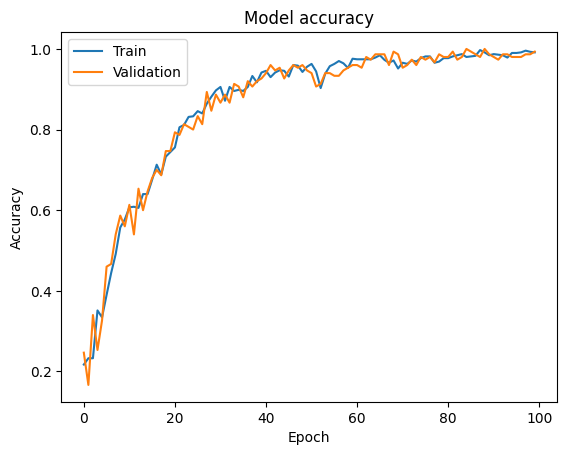

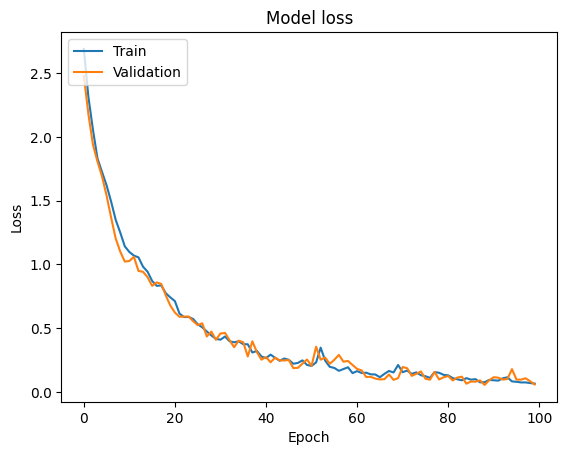

In [65]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [68]:
from sklearn.model_selection import KFold
import numpy as np

# Define number of splits for k-fold
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results from each fold
fold_accuracies = []
fold_losses = []

for train_index, val_index in kf.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Reshape data for CNN + LSTM input
    X_train_fold_reshaped = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
    X_val_fold_reshaped = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], 1)

    # Create the model for each fold
    model = create_cnn_lstm_model(input_shape)
    
    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the current fold
    history = model.fit(X_train_fold_reshaped, y_train_fold, 
                        validation_data=(X_val_fold_reshaped, y_val_fold),
                        epochs=100, 
                        batch_size=32, 
                        verbose=2)

    # Evaluate the model on the validation set of this fold
    val_loss, val_accuracy = model.evaluate(X_val_fold_reshaped, y_val_fold, verbose=3)
    
    # Store the results
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)

# Calculate the average accuracy and loss across all folds
average_accuracy = np.mean(fold_accuracies)
average_loss = np.mean(fold_losses)

print(f"Average Accuracy across {num_folds} folds: {average_accuracy:.4f}")
print(f"Average Loss across {num_folds} folds: {average_loss:.4f}")


Epoch 1/100
25/25 - 5s - 185ms/step - accuracy: 0.1863 - loss: 2.6335 - val_accuracy: 0.1650 - val_loss: 2.3881
Epoch 2/100
25/25 - 2s - 61ms/step - accuracy: 0.2200 - loss: 2.2074 - val_accuracy: 0.2900 - val_loss: 2.0603
Epoch 3/100
25/25 - 2s - 61ms/step - accuracy: 0.3225 - loss: 1.9239 - val_accuracy: 0.3250 - val_loss: 1.7753
Epoch 4/100
25/25 - 1s - 57ms/step - accuracy: 0.4150 - loss: 1.5687 - val_accuracy: 0.5350 - val_loss: 1.3332
Epoch 5/100
25/25 - 1s - 58ms/step - accuracy: 0.4863 - loss: 1.3796 - val_accuracy: 0.5550 - val_loss: 1.2256
Epoch 6/100
25/25 - 2s - 60ms/step - accuracy: 0.5462 - loss: 1.2058 - val_accuracy: 0.6150 - val_loss: 1.0850
Epoch 7/100
25/25 - 2s - 63ms/step - accuracy: 0.5850 - loss: 1.1286 - val_accuracy: 0.6600 - val_loss: 1.0060
Epoch 8/100
25/25 - 2s - 61ms/step - accuracy: 0.6125 - loss: 1.0434 - val_accuracy: 0.6050 - val_loss: 1.0451
Epoch 9/100
25/25 - 1s - 59ms/step - accuracy: 0.6288 - loss: 1.0063 - val_accuracy: 0.6700 - val_loss: 0.9171


In [69]:
from sklearn.metrics import confusion_matrix

In [70]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Get predictions for training, validation, and test data
train_predictions = model.predict(X_train_reshaped)
train_predicted_labels = np.argmax(train_predictions, axis=1)

val_predictions = model.predict(X_val_reshaped)
val_predicted_labels = np.argmax(val_predictions, axis=1)

test_predictions = model.predict(X_test_reshaped)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Class labels (assuming you have 5 classes: AS, MS, MR, MVP, Normal)
classes = ['Aortic Stenosis', 'Mitral Stenosis', 'Mitral Regurgitation', 'Mitral Valve Prolapse', 'Normal']

# Plot confusion matrix for training data
plot_confusion_matrix(y_train, train_predicted_labels, classes, 'Training Set')

# Plot confusion matrix for validation data
plot_confusion_matrix(y_val, val_predicted_labels, classes, 'Validation Set')

# Plot confusion matrix for test data (optional, if you have a test set)
plot_confusion_matrix(y_test, test_predicted_labels, classes, 'Test Set')

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>